In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import PIL.Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/trainset.zip -d /content/drive/MyDrive/dogtrainset


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/dogtrainset/A_kZuAQLYhiQgAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_k_KTTJwWrMMAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_k_QjTqLQl1MAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_k_kmR6ESJiIAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_ka23Rpt4o2MAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_kaa7RoBkIS25-HlLoiGAEgAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_kb9JS6BQxNEAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_kbPFRoKT7vQAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_kbQOR7vf9O4AAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_kbUKQLVvEWYAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: /content/drive/MyDrive/dogtrainset/A_kbUrS7NQRSoAAAAAAAAAAAAAAQAAA

In [4]:
DIR = '/content/drive/MyDrive/dogtrainset' #path

In [5]:
#Loading images into list
image_paths = []

for image_name in os.listdir(DIR):
    image_paths.append(os.path.join(DIR, image_name))

In [6]:
image_paths[:5]

['/content/drive/MyDrive/dogtrainset/02e5218a80b44139ab07c547e1d6c4b9.jpg',
 '/content/drive/MyDrive/dogtrainset/0rDoiEPPSFGdqf-Ujd7vtwAAACMAARAD.jpg',
 '/content/drive/MyDrive/dogtrainset/17B1o7cWTjyaf2jgMpoGvQAAACMAARAD.jpg',
 '/content/drive/MyDrive/dogtrainset/2f46a898f04348df85ec3e5f7413711f.jpg',
 '/content/drive/MyDrive/dogtrainset/3052ac86257e408a9d03cb9c8413ace0.jpg']

In [7]:
len(image_paths)

20000

# Preprocessing

In [8]:
train_images=[]

for path in image_paths:
    img = PIL.Image.open(path)
    img = img.resize((64,64))
    image = np.array(img)
    train_images.append(image)


In [9]:
train_images = np.array(train_images)

In [10]:
train_images = train_images.reshape(train_images.shape[0],64,64,3).astype('float32')

In [11]:
# normalize (0,255) => (-1,1)   (255-127.5)/127.5 = 1 //////  (0-127.5)/127.5 = -1
train_images = (train_images-127.5)/127.5

In [12]:
train_images[0]

array([[[ 0.06666667, -0.06666667, -0.22352941],
        [ 0.04313726, -0.08235294, -0.24705882],
        [ 0.05882353, -0.05882353, -0.23921569],
        ...,
        [-0.1764706 , -0.28627452, -0.43529412],
        [-0.2       , -0.31764707, -0.4745098 ],
        [-0.21568628, -0.3254902 , -0.49019608]],

       [[ 0.03529412, -0.08235294, -0.24705882],
        [-0.01960784, -0.13725491, -0.31764707],
        [ 0.00392157, -0.11372549, -0.28627452],
        ...,
        [-0.19215687, -0.29411766, -0.44313726],
        [-0.09803922, -0.21568628, -0.38039216],
        [ 0.05098039, -0.09803922, -0.27058825]],

       [[ 0.23137255,  0.08235294, -0.09803922],
        [ 0.24705882,  0.09019608, -0.09019608],
        [ 0.16078432,  0.01960784, -0.16078432],
        ...,
        [-0.03529412, -0.14509805, -0.3019608 ],
        [ 0.04313726, -0.07450981, -0.23137255],
        [-0.03529412, -0.12156863, -0.27058825]],

       ...,

       [[-0.60784316, -0.58431375, -0.56078434],
        [-0

# Create Generator and Descriminator

In [14]:
# latent dimension for random noise
LATENT_DIM = 300
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

# Generator Model

In [15]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             9863168   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                              

# Discriminator Model

In [16]:
model = Sequential(name='discriminator')
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

# Create GAN

> Indented block



In [17]:
class GAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [19]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=300):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

# Train

In [20]:
gan = GAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [21]:
D_LR = 0.0001
G_LR = 0.0003
gan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [22]:
N_EPOCHS = 20
gan.fit(train_images, epochs=N_EPOCHS, callbacks=[GANMonitor()])

Epoch 1/20
  6/625 [..............................] - ETA: 54s - d_loss: 0.6869 - g_loss: 5.0856

625/625 [==============================] - 76s 92ms/step - d_loss: -0.1426 - g_loss: 10.0868
Epoch 2/20
625/625 [==============================] - 60s 95ms/step - d_loss: 0.4311 - g_loss: 5.4051
Epoch 3/20
625/625 [==============================] - 61s 98ms/step - d_loss: 0.5252 - g_loss: 2.5666
Epoch 4/20
625/625 [==============================] - 62s 100ms/step - d_loss: 0.5956 - g_loss: 1.9257
Epoch 5/20
625/625 [==============================] - 63s 100ms/step - d_loss: 0.5657 - g_loss: 1.9086
Epoch 6/20
625/625 [==============================] - 63s 101ms/step - d_loss: 0.5604 - g_loss: 1.8620
Epoch 7/20
625/625 [==============================] - 63s 101ms/step - d_loss: 0.5665 - g_loss: 1.7355
Epoch 8/20
625/625 [==============================] - 63s 101ms/step - d_loss: 0.5799 - g_loss: 1.5992
Epoch 9/20
625/625 [==============================] - 63s 101ms/step - d_loss: 0.5781 - g_loss: 1.5829
Epoch 10/20
625/625 [==============================] - 63s 101ms/step - d_loss: 0.580

# Results

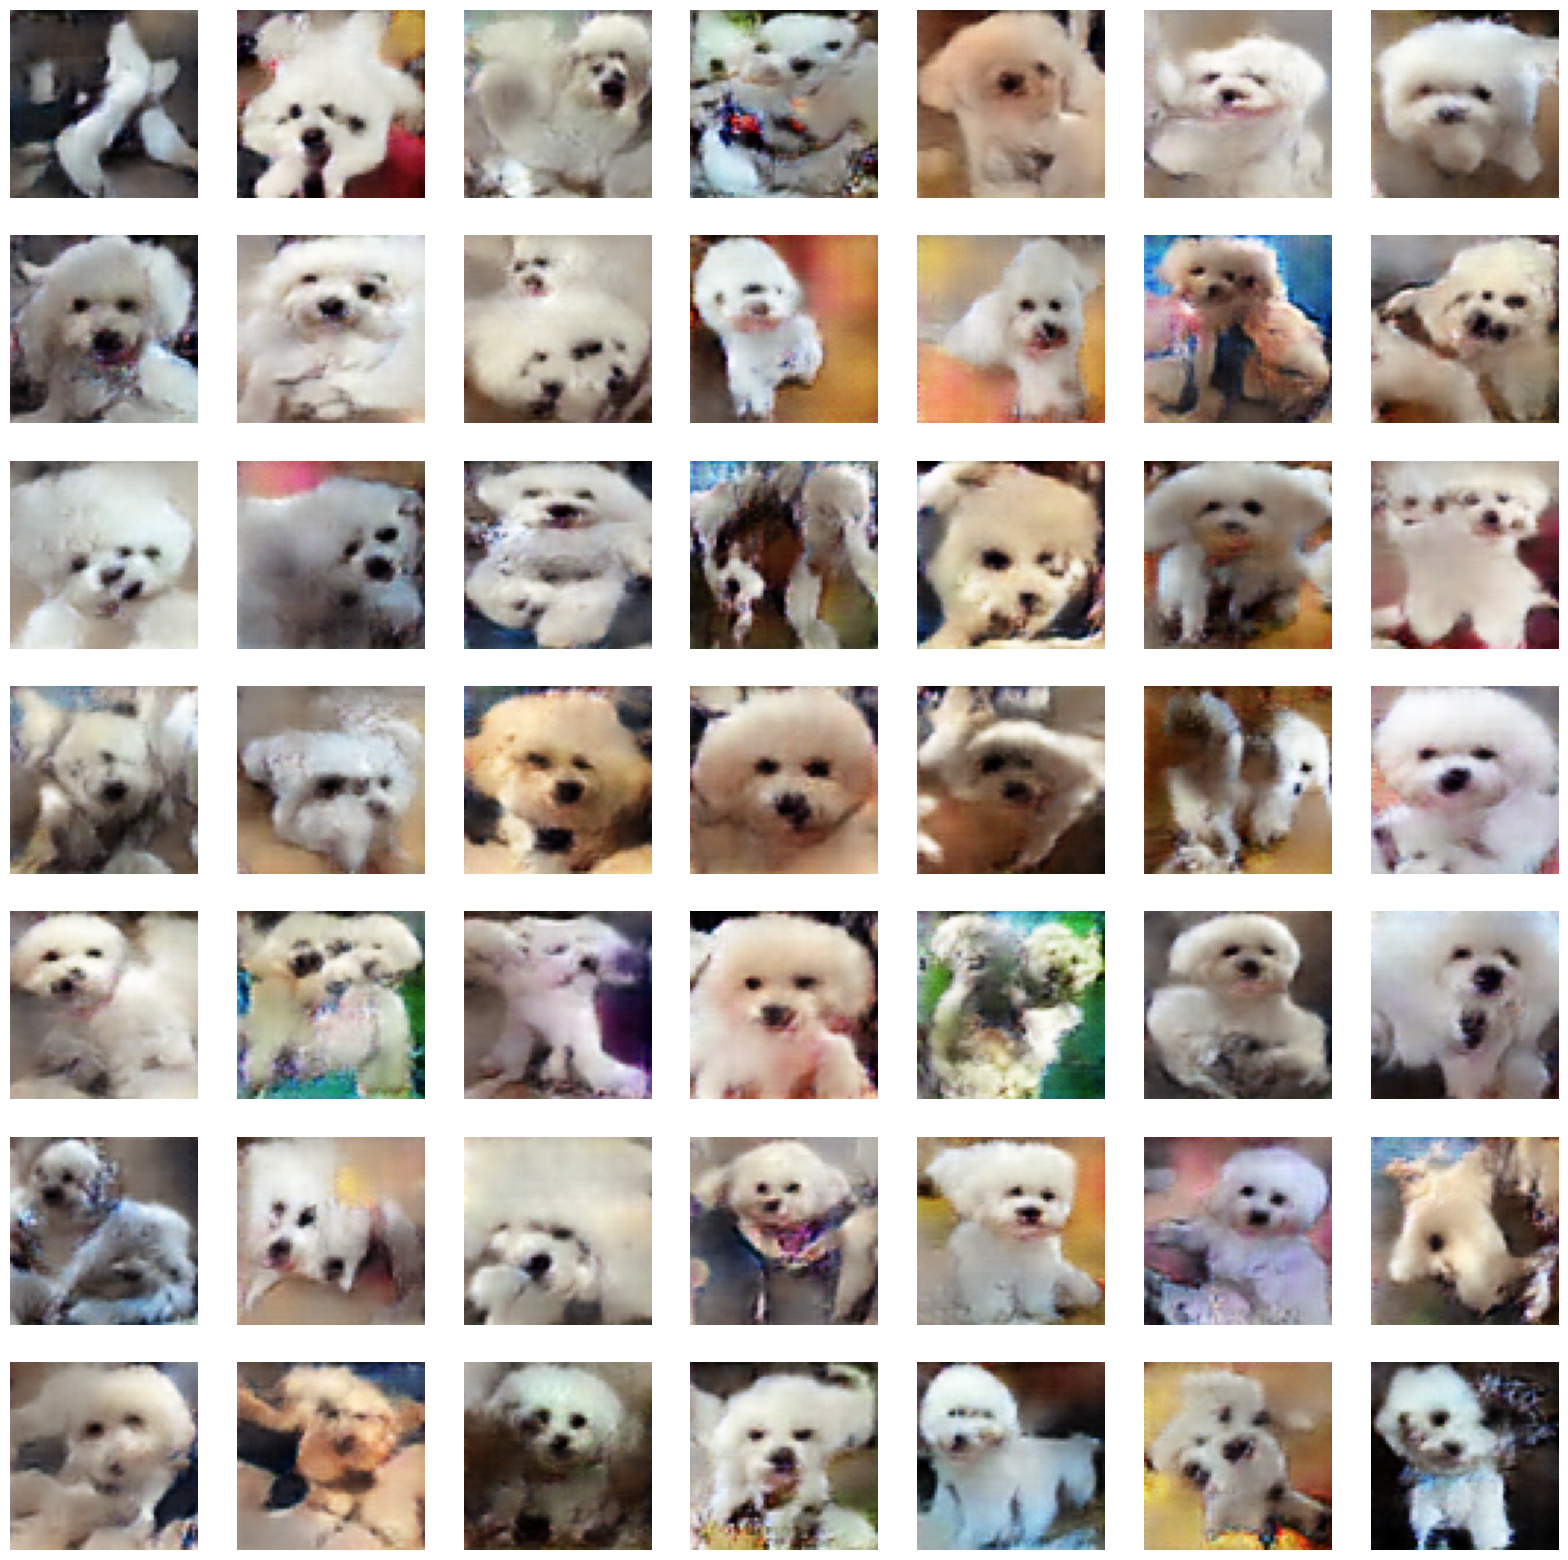

In [28]:
# plot 50 generated images
plt.figure(figsize=(20,20))

for i in range(49):
    plt.subplot(7,7,i+1)
    #generate random noise for each image
    noise=tf.random.normal([1,300])
    mg = gan.generator(noise)
    #denormalize
    mg = (mg*127.5)+127.5

    mg.numpy()
    image = array_to_img(mg[0])

    plt.imshow(image)
    plt.axis('off')